# Vanilla Policy Gradient

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device: ", DEVICE)

Using device:  mps


In [2]:
class PolicyNetwork(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes a neural network that estimates the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """
        super().__init__()

        hidden_space1 = 16 
        hidden_space2 = 32

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        # mean values
        action_means = self.policy_mean_net(shared_features)

        # std values: log(1 + exp(x)) ensures that the std is always positive
        action_stddevs = torch.log(1 + torch.exp(self.policy_stddev_net(shared_features)))

        return action_means, action_stddevs
    

class ReinforceAgent:

    def __init__(
            self, 
            obs_space_dims, 
            action_space_dims, 
            eps = 1e-6    
    ):
        self.eps = eps # epsilon for numerical stability
        self.net = PolicyNetwork(obs_space_dims, action_space_dims).to(DEVICE)
        
    def get_action(self, obs):
        
        # Get distribution
        x = torch.Tensor(obs).float().to(DEVICE)
        mu, std = self.net(x)
        distribution = Normal(mu + self.eps, std + self.eps)

        # Sample action
        action = distribution.sample()
        log_prob_action_give_state = distribution.log_prob(action)

        return action, log_prob_action_give_state
    

def run_episode(agent, env, gamma = 0.99, seed = None): 

    # Run
    episode = []
    obs = None    
    while True:

        # Next step
        if obs is None: 
            obs, _ = env.reset(seed = seed)
            reward = 0
            reward = np.nan
        else:
            obs, reward, terminated, truncated, _ = env.step(action.cpu().numpy())
            if terminated or truncated:
                episode.append({
                    "position": obs[0],
                    "angle": obs[1],
                    "velocity": obs[2],
                    "angular_velocity": obs[3],
                    "reward": reward,
                })
                break

        # Get action
        action, log_prob_action_give_state = agent.get_action(obs)
    
        episode.append({
            "position": obs[0],
            "angle": obs[1],
            "velocity": obs[2],
            "angular_velocity": obs[3],
            "reward": reward,
            "action": action,
            "log_prob_action_give_state": log_prob_action_give_state
        })


    # Analyze: Add discounted return
    df_episode = pd.DataFrame(episode)
    
    discounted_return = []
    _discounted_return = 0 
    for r in df_episode.reward.to_list()[::-1]:
        _discounted_return = r + gamma * _discounted_return
        discounted_return.insert(0, _discounted_return)

    df_episode["discounted_future_return"] = pd.Series(discounted_return)

    # Return
    return df_episode


def update_policy(optimizer, df_episode):

    # Compute loss
    loss = 0
    for i in range(len(df_episode)-1):
        R = df_episode.loc[i+1, "discounted_future_return"]
        p = df_episode.loc[i, "log_prob_action_give_state"].mean() # Mean to boil it down to a scalar
        loss += R * p
    loss *= -1

    # Update the policy network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

def init_players(lr=1e-4, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    env = gym.make("InvertedPendulum-v4", render_mode='rgb_array')
    obs_space_dims = env.observation_space.shape[0]
    action_space_dims = env.action_space.shape[0]
    agent = ReinforceAgent(obs_space_dims, action_space_dims)
    optimizer = torch.optim.AdamW(agent.net.parameters(), lr=lr)
    return env, agent, optimizer    

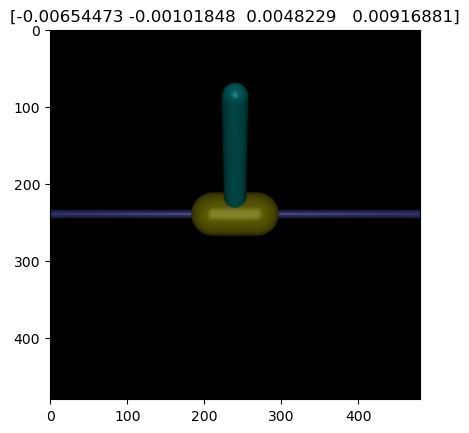

In [3]:
# Example

env, agent, optimizer  = init_players()

state, _ = env.reset()
plt.imshow(env.render())
plt.title(state)
plt.show()

In [4]:
# Sanity check
env, agent, optimizer = init_players(seed=1234)
df_episode = run_episode(agent, env, seed=None)
loss = update_policy(optimizer, df_episode)
df_episode

,position,angle,velocity,angular_velocity,reward,action,log_prob_action_give_state,discounted_future_return
0,-0.006772,0.006834,-0.001516,0.004576,NaN,"[tensor(-0.1882, device='mps:0')]","[tensor(-0.6543, device='mps:0', grad_fn=<Unbi...",NaN
1,-0.008104,0.010101,-0.064875,0.157297,1.0,"[tensor(-1.6586, device='mps:0')]","[tensor(-2.6557, device='mps:0', grad_fn=<Unbi...",3.940399
2,-0.021733,0.041933,-0.615115,1.422392,1.0,"[tensor(-1.0569, device='mps:0')]","[tensor(-1.6123, device='mps:0', grad_fn=<Unbi...",2.970100
3,-0.053222,0.114083,-0.958974,2.186600,1.0,"[tensor(0.0476, device='mps:0')]","[tensor(-0.4447, device='mps:0', grad_fn=<Unbi...",1.990000
4,-0.091127,0.200446,-0.937691,2.148405,1.0,NaN,NaN,1.000000


### Experiment

Some tutorial suggested to keep the environment fixed for some episodes and then change it. I don't think this is necessary. I think it is more important to change the environment after each episode. But let's test here.

In [5]:
def validate_agent(agent, env, n_episodes=100):
    logs = []
    episodes = []
    for _ in range(n_episodes):
        df_episode = run_episode(agent, env, seed=None)
        episodes.append(df_episode)
        logs.append({"loss": loss.item(), "episode_length": len(df_episode)})
    return pd.DataFrame(logs), episodes

def run_strategy_1(n_episodes):
    env, agent, optimizer = init_players(seed=1234)
    logs = []
    for i in range(n_episodes):        
        df_episode = run_episode(agent, env, seed=None)
        loss = update_policy(optimizer, df_episode)
        print(f"{i:>10} | {loss.item():>10.3f} | {len(df_episode):>5}", end="\r")
        logs.append({"loss": loss.item(), "episode_length": len(df_episode)})
    df_train = pd.DataFrame(logs)
    
    df_test, _ = validate_agent(agent, env, n_episodes=100)

    return df_train, df_test, agent

def run_strategy_2(n_episodes, seeds=[1,2,3,4]):
    env, agent, optimizer = init_players(seed=1234)
    logs = []
    for seed in seeds:
        for i in range(n_episodes//len(seeds)):        
            df_episode = run_episode(agent, env, seed=seed)
            loss = update_policy(optimizer, df_episode)
            print(f"{i:>10} | {loss.item():>10.3f} | {len(df_episode):>5}", end="\r")
            logs.append({"loss": loss.item(), "episode_length": len(df_episode), "seed": seed})
    df_train = pd.DataFrame(logs)

    df_test, _ = validate_agent(agent, env, n_episodes=100)
    
    return df_train, df_test, agent
    
n_episodes = 5000
df_train_1, df_test_1, agent_1 = run_strategy_1(n_episodes)
df_train_2, df_test_2, agent_2 = run_strategy_2(n_episodes, seeds=[1,2,3,4,5])

Seems like it really does not help us, at least in this example.

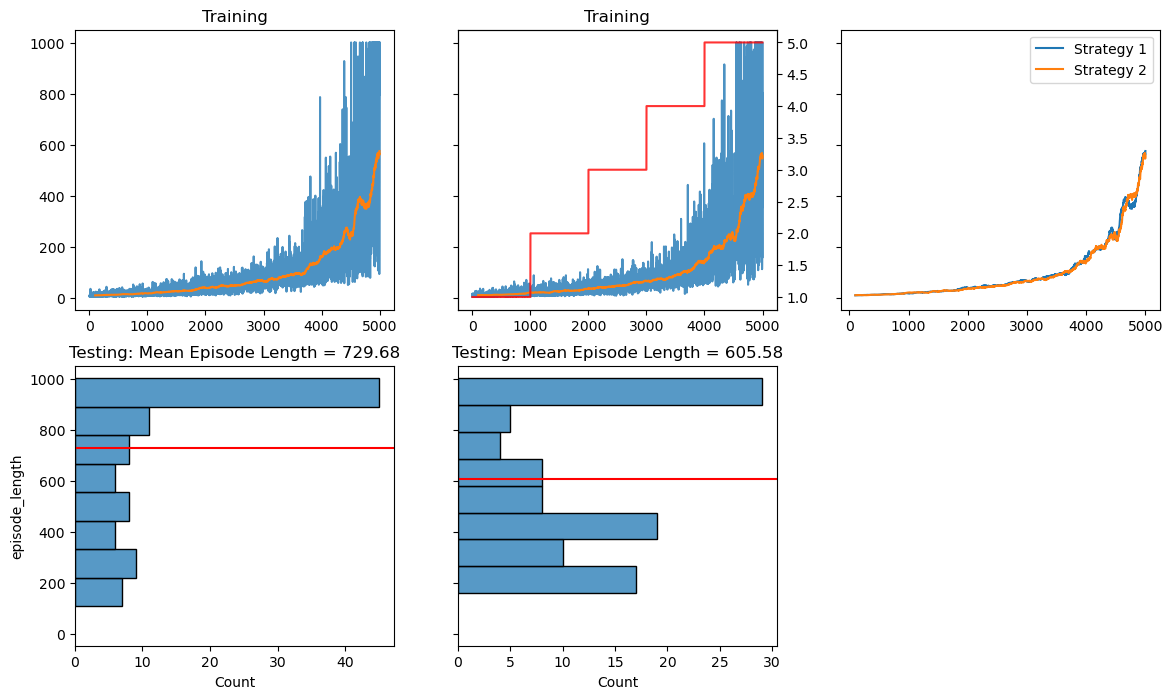

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), sharey=True)

for ax, df_logs in zip(axs[0,:], [df_train_1, df_train_2]):
    ax.plot(df_logs.index, df_logs.episode_length, alpha=0.8)
    ax.plot(df_logs.index, df_logs.episode_length.rolling(100).mean())
    if "seed" in df_logs.columns:
        ax2 = ax.twinx()
        ax2.plot(df_logs.index, df_logs.seed, alpha=0.8, color="red")
    ax.set_title("Training")

for ax, df_logs in zip(axs[1,:], [df_test_1, df_test_2]):
    sns.histplot(data=df_logs, y="episode_length", ax=ax)
    ax.axhline(df_logs.episode_length.mean(), color="red")
    ax.set_title("Testing: Mean Episode Length = {:.2f}".format(df_logs.episode_length.mean()))

axs[0,2].plot(df_train_1.index, df_train_1.episode_length.rolling(100).mean(), label="Strategy 1")
axs[0,2].plot(df_train_2.index, df_train_2.episode_length.rolling(100).mean(), label="Strategy 2")
axs[0,2].legend()
axs[1,2].remove()
plt.show()

Let's compare the trajectory of the rod (its angle) of a trained agent versus and untrained one.

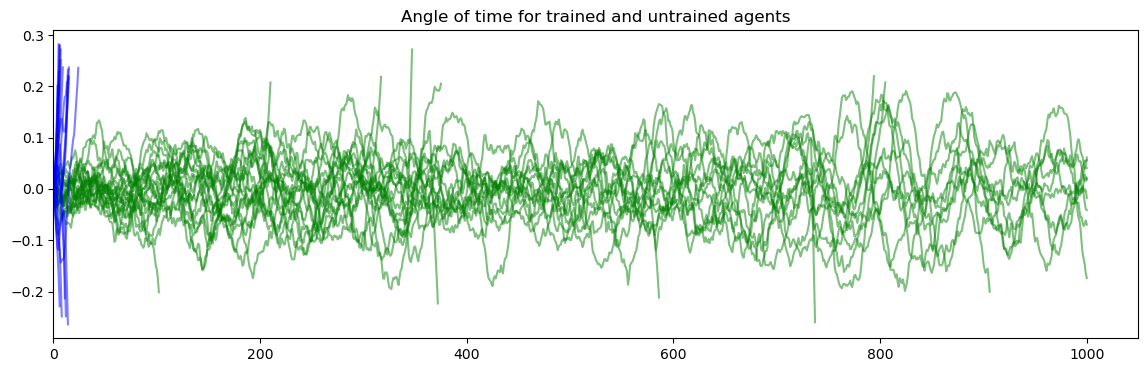

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(14, 4), sharey=True)

n_episodes = 20
_, episodes_trained = validate_agent(agent_1, env, n_episodes=n_episodes)
_, agent_untrained, _ = init_players(seed=1234)
_, episodes_untrained = validate_agent(agent_untrained, env, n_episodes=n_episodes)

colors = ["green", "blue"]
for i, episodes in enumerate([episodes_trained, episodes_untrained]):
    for df_episode in episodes:
        ax.plot(df_episode.index, df_episode.angle, color=colors[i], alpha=0.5)
ax.set_title("Angle over time for trained (green) and untrained (blue) agents")
ax.set_xlim(0, None)
plt.show()